In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
import os
os.environ['PYSPARK_PYTHON'] = "C:/NonOs/Apps/Anaconda/envs/MLE/python"

In [4]:
spark = SparkSession.builder.appName("Lab4").getOrCreate()
parquet_df = spark.read.parquet("food_clus_10.parquet")

In [5]:
#Подготовка данных
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=['energy_100g', 'proteins_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'energy-kcal_100g',
       'saturated-fat_100g', 'salt_100g', 'sodium_100g', 'fiber_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'], outputCol="features")
df = assembler.transform(parquet_df)

# Scale the features column
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [6]:
# модель кластеризации
kmeans = KMeans(
    k=10,
    featuresCol='features',
    predictionCol='cluster10',
    seed=42
)

#модель регрессии
logres = LogisticRegression(
    maxIter=30,
    family='multinomial',
    featuresCol='features',
    labelCol='cluster10',
    predictionCol='class'
)

#создание пайплайна
pipeline = Pipeline(stages=[kmeans, logres])

In [7]:
model = pipeline.fit(df)

kmeans_info = model.stages[0].summary
logres_info = model.stages[1].summary

#Вывод информации
print(f'Cluster sizes: {kmeans_info.clusterSizes}')
print(f'Accuracy: {logres_info.accuracy}')
print(f'Precision: {logres_info.weightedPrecision}')
print(f'Recall: {logres_info.weightedRecall}')
print(f'TPR: {logres_info.weightedTruePositiveRate}')
print(f'TNR: {logres_info.weightedFalsePositiveRate}')
print(f'FPR: {logres_info.weightedFalsePositiveRate}')
print(f'FNR: {logres_info.weightedFalsePositiveRate}')

Cluster sizes: [95, 2, 165, 138, 177, 111, 140, 86, 5, 83]
Accuracy: 0.8143712574850299
Precision: 0.8069169391929862
Recall: 0.8143712574850299
TPR: 0.8143712574850299
TNR: 0.026581890420779408
FPR: 0.026581890420779408
FNR: 0.026581890420779408


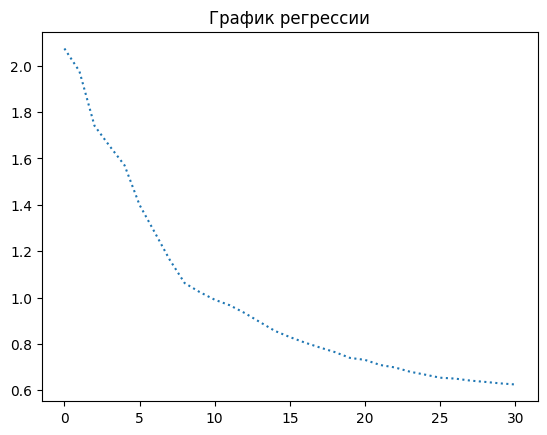

In [9]:
import matplotlib.pyplot as plt
plt.title('График регрессии')
plt.plot(logres_info.objectiveHistory, linestyle = 'dotted')
plt.show()

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

df_prediction = model.transform(df)
new_df = df_prediction.selectExpr("cluster10", "class")
metrics = MulticlassMetrics(new_df.rdd)

# Вывод матрицы ошибок
confusionMatrix = metrics.confusionMatrix()
print(confusionMatrix)

In [ ]:
from pyspark.ml.feature import Normalizer
from operator import add


df_normed = df_prediction.rdd.map(lambda x: (x['class'], x['probability'])) \
    .reduceByKey(add).toDF(['class', 'probability'])

norm_func = Normalizer(inputCol='probability', outputCol='normed', p=1)
norm_func = norm_func.transform(df_normed).rdd.map(lambda x: (x['class'], x['norm_func'].toArray().max()))

In [23]:
info = []
for label, confidence in normed.collect():
    info.append([int(label), confidence]) 

info = sorted(info, key=lambda x: x[0])
for l, c in info:
    print(f'Class: {l} confidence: {c}')

Class: 0 confidence: 0.615044356512591
Class: 1 confidence: 0.9264657459619493
Class: 2 confidence: 0.9747727889490799
Class: 3 confidence: 0.8851089541064854
Class: 4 confidence: 0.8092216908810466
Class: 5 confidence: 0.7185501771673591
Class: 6 confidence: 0.6253139441462524
Class: 7 confidence: 0.5139341497679389
Class: 8 confidence: 0.5999386483341534
Class: 9 confidence: 0.48319649097135525


In [20]:
info

[[5, 0.7185501771673591],
 [0, 0.615044356512591],
 [6, 0.6253139441462524],
 [4, 0.8092216908810466],
 [2, 0.9747727889490799],
 [3, 0.8851089541064854],
 [9, 0.48319649097135525],
 [7, 0.5139341497679389],
 [8, 0.5999386483341534],
 [1, 0.9264657459619493]]